# 1. 读取数据

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time

warnings.filterwarnings('ignore')
%matplotlib inline

train = pd.read_csv('../data/f_train.csv')
test = pd.read_csv('../data/f_test.csv')
num2label = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS', 
    3: 'WALKING_DOWNSTAIRS', 
    4: 'SITTING', 
    5: 'STANDING', 
    6: 'LAYING'
    }
label2num = {v: k for k, v in num2label.items()}

X_train = train.drop(['subject', 'activity'], axis=1)
y_train = train['activity'].map(label2num)
X_test = test.drop(['subject', 'activity'], axis=1)
y_test = test['activity'].map(label2num)

# 2. 指标

In [44]:
# 紧密度
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics import adjusted_rand_score, confusion_matrix,  accuracy_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.optimize import linear_sum_assignment

# 紧密度
def compute_compactness(X, labels):
    if not isinstance(X, np.ndarray):
        X = X.values
    unique_labels = np.unique(labels)
    compactness = 0.0
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_center = cluster_points.mean(axis=0)  # 计算质心
        compactness += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1))  # 簇内距离总和
    return compactness

# 分离度
def compute_separation(X, labels):
    if not isinstance(X, np.ndarray):
        X = X.values
    unique_labels = np.unique(labels)
    cluster_centers = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_centers.append(cluster_points.mean(axis=0))  # 计算质心
    cluster_centers = np.array(cluster_centers)
    pairwise_dist = pairwise_distances(cluster_centers)  # 质心两两之间的距离
    np.fill_diagonal(pairwise_dist, np.inf)  # 忽略自身到自身的距离（置为无穷大）
    return pairwise_dist.min()

# 准确率
def cluster_accuracy(true_labels, labels):
    conf_matrix = confusion_matrix(true_labels, labels + 1)
    print(conf_matrix)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    print(row_ind, col_ind)
    mapping = dict(zip(col_ind, row_ind))
    mapped_labels = np.array([mapping[label] for label in labels])
    accuracy = accuracy_score(true_labels, mapped_labels)
    return accuracy
def print_metrics(X, labels, true_labels):
    # 内在指标
    print('Internal Indices')
    # 紧凑度
    compactness = compute_compactness(X, labels)
    print(f'compactness:{compactness: .3f}')

    # 分离度
    separation = compute_separation(X, labels)
    print(f'separation:{separation: .3f}')

    # 衡量簇内点的紧密度与簇间点的分离度，取值范围：[-1, 1]，值越接近 1，说明聚类效果越好。
    SC = silhouette_score(X, labels)  
    print(f'Silhouette Coefficient:{SC: .3f}')

    # # 衡量簇间方差和簇内方差的比值，值越大，说明簇间分离度大，簇内紧密度高。
    # CH = calinski_harabasz_score(X, labels)  
    # print(f'Calinski-Harabasz Index:{CH: .3f}')

    # # 衡量簇间距离和簇内距离的比值，值越小，说明聚类效果越好
    # DB = davies_bouldin_score(X, labels) 
    # print(f'Davies-Bouldin Index:{DB: .3f}\n')


    # 外在指标
    print('External Indices:')

    acc = cluster_accuracy(true_labels, labels)
    print(f'Accuracy:{acc: .3f}')

    # 取值范围：[-1, 1]，值越接近 1，说明聚类结果与真实标签一致性越高。
    ARI = adjusted_rand_score(true_labels, labels) 
    print(f'Adjusted Rand Index:{ARI: .3f}')

    # #取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
    # MI = normalized_mutual_info_score(true_labels, labels) 
    # print(f'Mutual Information:{MI: .3f}')

    #取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
    # FMI = fowlkes_mallows_score(true_labels, labels)
    # print(f'FMI:{FMI: .3f}')
    return compactness, separation, SC, acc, ARI

# 3. 层次聚类

层次聚类需要计算簇之间的距离，以下是常见的距离度量方法：

- 单链接（Single Linkage）：两个簇中最近点之间的距离。
- 完全链接（Complete Linkage）：两个簇中最远点之间的距离。
- 平均链接（Average Linkage）：两个簇中所有点对之间距离的平均值。
- Ward’s 方法：通过最小化簇内平方误差（within-cluster variance）来合并簇。

### 3.1 聚合型层次聚类（Agglomerative Hierarchical Clustering）

- 原理：从每个数据点作为单独的簇开始，不断合并最近的簇，直到所有数据点合并为一个簇，形成层次结构。
- 优点：
简单直观，适用于小数据集。
- 缺点：
难以处理大规模数据集，计算复杂度较高。

In [63]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 定义参数网格
param_grid = {
    'standard_scaler': [True, False],
    'pca__n_components': [0.8, 0.9, 0.99, False],
    'agglomerative__affinity': ['euclidean', 'manhattan', 'cosine'],
    'agglomerative__linkage': ['ward', 'complete', 'average', 'single']
}

best_score = -1
best_params = {}
run_times = []
# 循环遍历参数网格
for standard_scaler in param_grid['standard_scaler']:
    for n_components in param_grid['pca__n_components']:
        for affinity in param_grid['agglomerative__affinity']:
            for linkage in param_grid['agglomerative__linkage']:
                # 跳过不兼容的参数组合
                if linkage == 'ward' and affinity != 'euclidean':
                    continue
                
                if standard_scaler and n_components:
                    pp = Pipeline([
                        ('sc', StandardScaler()),
                        ('pca', PCA(n_components=n_components)),
                    ])
                elif not standard_scaler and n_components:
                    pp = PCA(n_components=n_components)
                elif not n_components:
                    pp = None
                if pp:
                    X_pca = pp.fit_transform(X_train)
                else:
                    X_pca = X_train
                model = AgglomerativeClustering(n_clusters=6, affinity=affinity, linkage=linkage)
                
                # 拟合模型并预测
                start_time = time.time()
                labels = model.fit_predict(X_pca)
                run_times.append(time.time() - start_time)

                # 计算 adjusted rand score
                score = adjusted_rand_score(y_train, labels)
                
                # 更新最佳参数和评分
                if score > best_score:
                    best_score = score
                    best_params = {
                        'standard_scaler': standard_scaler,
                        'pca__n_components': n_components,
                        'agglomerative__affinity': affinity,
                        'agglomerative__linkage': linkage
                    }

# 输出最佳参数和评分
print("Best parameters found: ", best_params)
print("Best adjusted rand score: ", best_score)
print(f"Average run time: {np.mean(run_times):.2f} ± {np.std(run_times):.2f} seconds")

Best parameters found:  {'standard_scaler': True, 'pca__n_components': False, 'agglomerative__affinity': 'euclidean', 'agglomerative__linkage': 'ward'}
Best adjusted rand score:  0.5128694931363761
Average run time: 2.33 ± 2.28 seconds


Internal Indices
compactness: 30654.137
separation: 2.922
Silhouette Coefficient: 0.109
External Indices:
[[   0  710  489    0    0   27]
 [   0  841  232    0    0    0]
 [   0   62  733    0    0  191]
 [   8    1    0  508  769    0]
 [   0    0    0  687  687    0]
 [1403    0    0    0    4    0]]
[0 1 2 3 4 5] [5 1 2 4 3 0]
Accuracy: 0.197
Adjusted Rand Index: 0.513


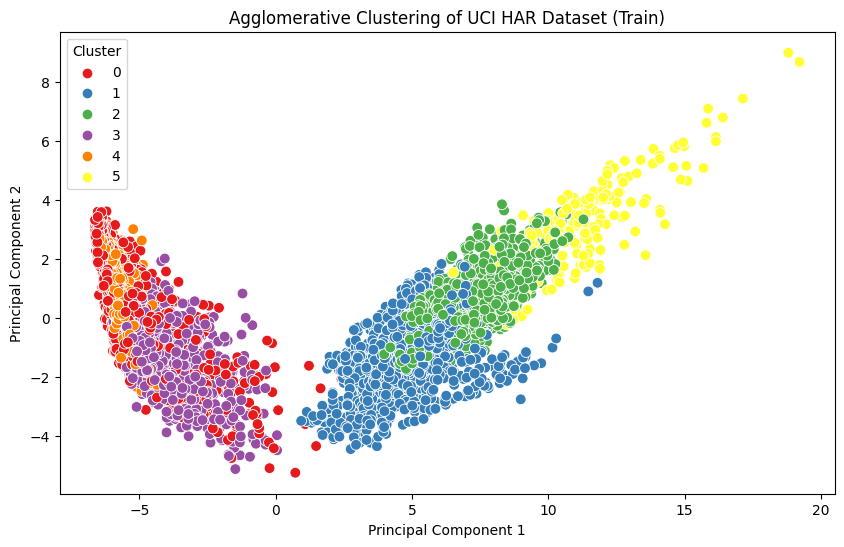

In [66]:
"""
Best parameters found:  
{
'standard_scaler': False, 
'pca__n_components': False, 
'agglomerative__affinity': 'euclidean', 
'agglomerative__linkage': 'ward'}
"""

# 使用最佳参数进行聚类

pp = Pipeline([
    ('pca', PCA(n_components=0.99))
])
X_pca = pp.fit_transform(X_train)
# X_pca = X_train.values
best_model = AgglomerativeClustering(n_clusters=6, linkage='ward', affinity='euclidean')
y_pred = best_model.fit_predict(X_train)

compactness, separation, SC, acc, ARI = print_metrics(X_train, y_pred, y_train)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette="Set1", s=60)
plt.title("Agglomerative Clustering of UCI HAR Dataset (Train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.savefig("../result/agg_best.pdf")
plt.show()

### 3.2 BIRCH

- 原理：通过构建一个树状数据结构（称为 CF 树，Clustering Feature Tree）来逐步聚类数据。CF 树由多个节点组成，每个节点包含一个簇的摘要信息。
- 优点
    - 高效性：BIRCH 通过一次扫描数据集即可找到一个初步的聚类结果，并通过少量额外扫描进一步优化，具有较高的时间效率。
    - 可扩展性：BIRCH 能够处理大规模数据集，适用于内存有限的情况。
    - 增量更新：BIRCH 可以动态地添加新数据点并更新聚类结果，而无需重新计算整个数据集。
- 缺点
    - 数据类型限制：BIRCH 仅适用于度量数值数据，不适用于非数值数据。
    - 顺序敏感：BIRCH 对数据点的插入顺序较为敏感，不同的插入顺序可能导致不同的聚类结果。
    - 参数依赖：BIRCH 的性能和聚类结果依赖于参数的选择，如阈值和簇的数量

In [67]:
from sklearn.cluster import Birch

pipeline = Pipeline([
    ('pca', PCA()),
    ('birch', Birch())
])

# 定义参数网格
param_grid = {
    'standard_scaler': [True, False],
    'pca__n_components': [0.8, 0.9, 0.99, False],
    'birch__threshold': [0.1, 0.2, 0.3, 0.4],
    'birch__branching_factor': [20, 30, 40, 50]
}


best_score = -1
best_params = {}
run_times = []
# 循环遍历参数网格
for standard_scaler in param_grid['standard_scaler']:
    for n_components in param_grid['pca__n_components']:
        for threshold in param_grid['birch__threshold']:
            for branching_factor in param_grid['birch__branching_factor']:
                
                if standard_scaler and n_components:
                    pp = Pipeline([
                        ('sc', StandardScaler()),
                        ('pca', PCA(n_components=n_components)),
                    ])
                elif not standard_scaler and n_components:
                    pp = PCA(n_components=n_components)
                elif not n_components:
                    pp = None
                if pp:
                    X_pca = pp.fit_transform(X_train)
                else:
                    X_pca = X_train
                model = Birch(n_clusters=6, branching_factor=branching_factor, threshold=threshold)
                
                # 拟合模型并预测
                start_time = time.time()
                labels = model.fit_predict(X_pca)
                run_times.append(time.time() - start_time)

                # 计算 adjusted rand score
                score = adjusted_rand_score(y_train, labels)
                
                # 更新最佳参数和评分
                if score > best_score:
                    best_score = score
                    best_params = {
                        'standard_scaler': standard_scaler,
                        'pca__n_components': n_components,
                        'birch__threshold': threshold,
                        'birch__branching_factor': branching_factor
                    }

# 输出最佳参数和评分
print("Best parameters found: ", best_params)
print("Best adjusted rand score: ", best_score)
print(f"Average run time: {np.mean(run_times):.2f} ± {np.std(run_times):.2f} seconds")


Best parameters found:  {'standard_scaler': False, 'pca__n_components': 0.8, 'birch__threshold': 0.4, 'birch__branching_factor': 30}
Best adjusted rand score:  0.5253368575058969
Average run time: 2.76 ± 1.92 seconds


Internal Indices
compactness: 19350.019
separation: 3.530
Silhouette Coefficient: 0.275
External Indices:
[[   0  367  830    0    0   29]
 [   0  106  964    0    0    3]
 [   0  525  237    0    0  224]
 [1126    0    1   42  117    0]
 [1323    0    0    0   51    0]
 [   0    0    0 1301  106    0]]
[0 1 2 3 4 5] [1 2 5 4 0 3]
Accuracy: 0.266
Adjusted Rand Index: 0.525


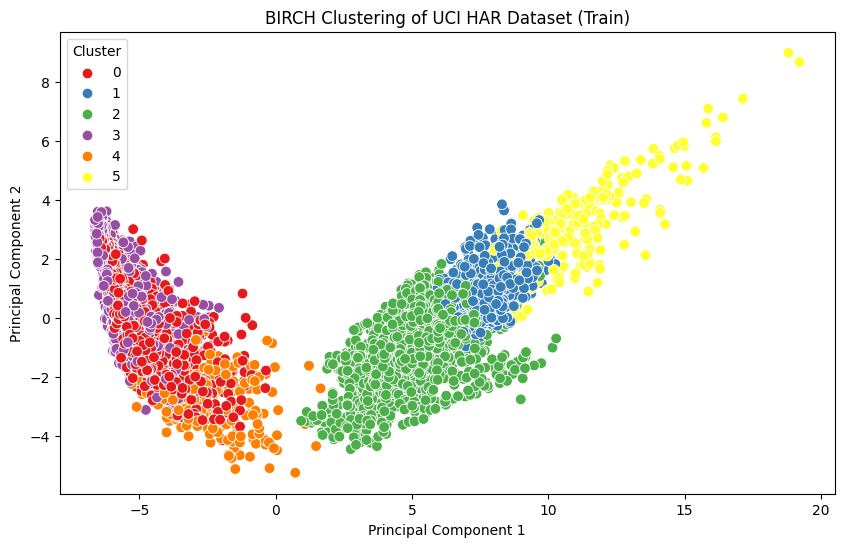

In [62]:
'''
Best parameters:  
{
'standard_scaler': False, 
'pca__n_components': 0.8, 
'birch__threshold': 0.4, 
'birch__branching_factor': 30
}
'''

# 使用最佳参数进行聚类

pca = PCA(0.8)
X_train_pca = pca.fit_transform(X_train)
best_model = Birch(n_clusters=6, branching_factor=30, threshold=0.4)
y_pred = best_model.fit_predict(X_train_pca)

compactness, separation, SC, acc, ARI = print_metrics(X_train_pca, y_pred, y_train)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_pred, palette="Set1", s=60)
plt.title("BIRCH Clustering of UCI HAR Dataset (Train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.savefig("../result/birch_best.pdf")
plt.show()